In [77]:
import findspark
findspark.init()
import pyspark

from pyspark.sql import SparkSession
from pyspark import SparkConf

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, VectorIndexer, StringIndexer, Normalizer, StandardScaler, MaxAbsScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator


# Algorithms
from pyspark.ml.classification import DecisionTreeClassifier, LinearSVC, RandomForestClassifier


# Others
from collections import OrderedDict

# Graphs libs
import matplotlib.pyplot as plt

# Supress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Spark context simple configuration
spark = SparkSession.builder.config(conf=SparkConf()).getOrCreate()

spark.version


'2.2.1'

In [78]:
%load_ext autoreload
%autoreload 2

from Helpers.technical_indicators import calc_ti
from Helpers.generated_features import features_from_OHLC
from Helpers.CustomTS import TrainValidationSplitSorted
from Helpers.best_model_params import *

from ProcessingData.processing import initial_processing, calc_profit, transform_date, train_test_split, complete_processing, simple_processing
from Stats.measures import calc_metrics, best_par
from Helpers.udf import BuyAndHoldClassifier, ReverseTradeClassifier

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
ManualSplit = True
SORT = True
CHUNKS = 6

CV = False

DEBUG = False
RANDOM_SEED = 1

In [80]:
# path_to_csv = "s3://stocksets100/Orlen.csv"
path = "./Datasets/Orlen.csv"
df = complete_processing(spark, path)

train, test = train_test_split(spark, df, CHUNKS, SORT, ManualSplit, RANDOM_SEED)

We have 839 training examples and 167 test examples. 



In [81]:
# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
featuresCols = df.columns
featuresCols.remove('Profit')
featuresCols.remove('id')
print(featuresCols)

['Volume', 'avg_price_5', 'avg_price_30', 'avg_price_365', 'ratio_avg_price_5_30', 'ratio_avg_price_5_365', 'ratio_avg_price_30_365', 'avg_volume_5', 'avg_volume_30', 'avg_volume_365', 'ratio_avg_volume_5_30', 'ratio_avg_volume_5_365', 'ratio_avg_volume_30_365', 'std_price_5', 'std_price_30', 'std_price_365', 'ratio_std_price_5_30', 'ratio_std_price_5_365', 'ratio_std_price_30_365', 'std_volume_5', 'std_volume_30', 'std_volume_365', 'ratio_std_volume_5_30', 'ratio_std_volume_5_365', 'ratio_std_volume_30_365', 'return_1', 'return_5', 'return_30', 'return_365', 'moving_avg_5', 'moving_avg_30', 'moving_avg_365', 'MACD', 'CCI', 'OBV', 'RSI']


In [82]:
# Patrameters grid testing
# classifier = DecisionTreeClassifier(
#     labelCol='Profit', featuresCol="features", minInfoGain=0.01,  maxBins=200)

classifier = RandomForestClassifier(
    labelCol='Profit', featuresCol="features", numTrees=50, maxBins=1000)
max_Depth_Range = [14]
min_InstancesPerNode = list(range(5, 15))
paramGrid = ParamGridBuilder() \
    .addGrid(classifier.maxDepth, max_Depth_Range).build() \

# classifier = LinearSVC(regParam=0.5, labelCol='Profit', featuresCol="features")
# max_Iter= [10]
# paramGrid = ParamGridBuilder() \
#     .addGrid(classifier.maxIter, max_Iter).build()

# We define an evaluation metric. This tells Validator how well we are doing by comparing the true
# labels with predictions.

evaluator = MulticlassClassificationEvaluator(
    labelCol=classifier.getLabelCol(),
    metricName='accuracy',
    predictionCol=classifier.getPredictionCol())

In [83]:
# Declare the CrossValidator, which runs model tuning for us.
if CV:
    validator = CrossValidator(
        estimator=classifier,
        evaluator=evaluator,
        estimatorParamMaps=paramGrid,
        numFolds=2)
else:
    validator = TrainValidationSplitSorted(
        chunks=CHUNKS,
        spark=spark,
        estimator=classifier,
        estimatorParamMaps=paramGrid,
        evaluator=evaluator)

In [84]:
# scaler = None
# scaler = Normalizer(inputCol="features", outputCol="features", p=1.0)
# scaler = StandardScaler(inputCol="rawFeatures", outputCol='features', withMean=True, withStd=True)
scaler = MaxAbsScaler(inputCol="rawFeatures", outputCol="features")

In [85]:
# Vector Assembler
# This concatenates all feature columns into a single feature vector in a new column "rawFeatures".
# Used for assembling features into a vector.
# We will pass all the columns that we are going to use for the prediction to the VectorAssembler and
# it will create a new vector column.
# Creating Final pipeline object
if scaler is not None:
    vectorAssembler_rt = VectorAssembler(
    inputCols=featuresCols, outputCol="rawFeatures")
    pipeline = Pipeline(stages=[vectorAssembler_rt,scaler, validator])
else:
    vectorAssembler_rt = VectorAssembler(
    inputCols=featuresCols, outputCol="features")
    pipeline = Pipeline(stages=[vectorAssembler_rt, validator])

In [86]:
# FITTING!
pipelineModel = pipeline.fit(train)

# Getting the Best Model
best_classifier = pipelineModel.stages[-1].bestModel

In [87]:
# Feature importance
final_features = best_classifier.featureImportances

feature_dict = {}
for feature, importance in zip(featuresCols, final_features):
    feature_dict[feature] = importance

feature_dict = OrderedDict(sorted(feature_dict.items(), key=lambda t: t[1], reverse=True)) 

i = 1
for feature, importance in feature_dict.items():
    print("{} ; {} ; {}".format(i, feature, round(importance, 3)))
    i+=1

1 ; Volume ; 0.063
2 ; RSI ; 0.051
3 ; ratio_std_price_5_30 ; 0.041
4 ; CCI ; 0.039
5 ; return_1 ; 0.038
6 ; ratio_std_price_5_365 ; 0.037
7 ; avg_price_5 ; 0.037
8 ; std_price_5 ; 0.035
9 ; return_5 ; 0.035
10 ; std_price_30 ; 0.034
11 ; return_30 ; 0.034
12 ; MACD ; 0.033
13 ; ratio_avg_price_5_30 ; 0.032
14 ; avg_price_365 ; 0.032
15 ; ratio_avg_price_5_365 ; 0.031
16 ; avg_price_30 ; 0.03
17 ; ratio_std_price_30_365 ; 0.03
18 ; ratio_avg_price_30_365 ; 0.029
19 ; std_price_365 ; 0.028
20 ; return_365 ; 0.028
21 ; moving_avg_5 ; 0.027
22 ; std_volume_365 ; 0.023
23 ; ratio_std_volume_30_365 ; 0.021
24 ; ratio_avg_volume_30_365 ; 0.021
25 ; std_volume_30 ; 0.02
26 ; avg_volume_365 ; 0.019
27 ; avg_volume_30 ; 0.019
28 ; OBV ; 0.019
29 ; ratio_std_volume_5_30 ; 0.018
30 ; ratio_std_volume_5_365 ; 0.017
31 ; avg_volume_5 ; 0.017
32 ; moving_avg_30 ; 0.017
33 ; ratio_avg_volume_5_365 ; 0.016
34 ; ratio_avg_volume_5_30 ; 0.013
35 ; std_volume_5 ; 0.012
36 ; moving_avg_365 ; 0.004


In [88]:
# Making Predictions!
predictions = pipelineModel.transform(test)

In [89]:
#evaluate results
calc_metrics(predictions)
print(best_par(best_classifier))

Summary Stats
DenseMatrix([[ 50.,  34.],
             [ 35.,  48.]])
accuracy  0.586826347305
sensitivity  0.588235294118
specificity  0.585365853659
precision  0.595238095238
Maximal depth is 14
Minimal instances per node is 1
(14, 1)


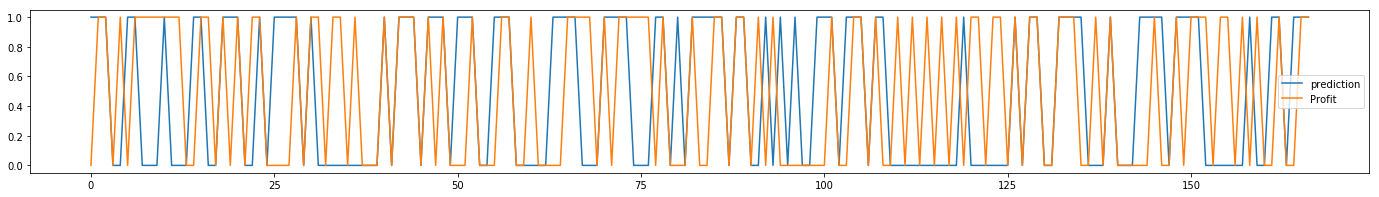

In [90]:
if DEBUG != True:
    df_to_plot_rt = predictions.select('prediction', 'Profit')
    df_to_plot_rt = df_to_plot_rt.toPandas()
    plt.figure(figsize=(24, 3))
    plt.plot(df_to_plot_rt)
    plt.legend(df_to_plot_rt.columns)
    plt.show()

In [91]:
import pandas as pd
i = 0
# path_to_csv = "s3://stocksets100/Orlen.csv"
path = "./Datasets/KGHA.csv"
df = complete_processing(spark, path)
ManualSplit = False
results = []
pipeline_test = Pipeline(stages=[vectorAssembler_rt,scaler, best_classifier])
# pipeline_test = Pipeline(stages=[vectorAssembler_rt, best_classifier])

for i in range(3):
    train, test = train_test_split(spark, df, CHUNKS, SORT, ManualSplit, RANDOM_SEED + i)
    predictions = pipeline_test.fit(test).transform(test)
    results.append(calc_metrics(predictions)['accuracy'])
    i+=1
    print("#########################################################################")

We have 909 training examples and 398 test examples. 

Summary Stats
DenseMatrix([[  85.,  122.],
             [  63.,  128.]])
accuracy  0.535175879397
sensitivity  0.574324324324
specificity  0.512
precision  0.410628019324
#########################################################################
We have 904 training examples and 403 test examples. 

Summary Stats
DenseMatrix([[ 102.,  118.],
             [  80.,  103.]])
accuracy  0.508684863524
sensitivity  0.56043956044
specificity  0.466063348416
precision  0.463636363636
#########################################################################
We have 905 training examples and 402 test examples. 



KeyboardInterrupt: 

In [ ]:
import pandas as pd
i = 0

path = "./Datasets/Orlen.csv"
df = simple_processing(spark, path)
ManualSplit = False
results = []
for i in range(30):
    train, test = train_test_split(spark, df, CHUNKS, SORT, ManualSplit, RANDOM_SEED + i)
    results.append(calc_metrics(test)['accuracy'])
    i+=1
    print("#########################################################################")

In [ ]:
from scipy import stats
stats_df = pd.DataFrame( {'Accuracy' : results})
print(stats_df)

In [ ]:
plt.boxplot(stats_df['Accuracy'], labels=stats_df.columns)
plt.show()